Activation thresholds with LIFE and cuff-like electrodes
========================================================

This script evaluates the activation threshold of myelinated fibers when stimulated with a cuff electrode and with a LIFE

In [10]:
import nrv
import matplotlib.pyplot as plt
import numpy as np

nrv.parameters.set_nrv_verbosity(2)

#Simulate with cuff

#Stimulus definition 
t_inter = 0
cath_an_ratio = 0
anod_first = False
pw = 50e-3          #stimulation PW is 50µs

#binary search parameters
amp_max = 600                   #maximum stimulation amplitude, in µs 
amp_tol = 5                   #binary search tolerance, in %

#Axon ranges from 1µm to 20µm
d_min = 2
d_max = 20
n_diam = 10
diam_list = np.round(np.linspace(d_min,d_max,num=n_diam))
model= 'MRG'
n_node = 20     #20 Node of Ranvier for each axon

# axon location
z_axon = 0	  # axon z position, in [um]
y_axon = 100  # axon z position, in [um]

##### electrodes definition
contact_width=500
contact_thickness=100
insulator_width=1000
insulator_thickness=500

### Simulation box size
Outer_D = 6     # in in [mm]

#### Nerve and fascicle geometry
Nerve_D = 1000      # in [um]
Fascicle_D = 800    # in [um]
perineurium_thickeness = 25 # in [um]


#dummy useless stimulus
start = 1
I_cathod = 10
I_anod = 0
T_cathod = pw
T_inter = t_inter
stim1 = nrv.stimulus()
stim1.biphasic_pulse(start, I_cathod, T_cathod, I_anod, T_inter)

thr_cuff =  []
for diam in diam_list:

    L=nrv.get_length_from_nodes(diam,n_node)

    print(f"CUFF - PW = {int(pw*1e3)}us - D_axon {diam}um")

    #set the FEM parameters
    extra_stim = nrv.FEM_stimulation()
    extra_stim.reshape_outerBox(Outer_D)
    extra_stim.reshape_nerve(Nerve_D, L)
    extra_stim.reshape_fascicle(Fascicle_D)

    #axon creation
    axon1 = nrv.myelinated(y_axon,z_axon,diam,L,rec='nodes',model=model) 
    n_node = len(axon1.x_nodes)
    x_elec = axon1.x_nodes[(n_node//2)]	# electrode x position, in [um]

    elec_1 = nrv.CUFF_electrode('CUFF_1', contact_length=contact_width,\
        contact_thickness=contact_thickness, insulator_length=insulator_width,\
        insulator_thickness=insulator_thickness, x_center=x_elec)

    # extracellular stimulation setup
    extra_stim.add_electrode(elec_1, stim1)
    axon1.attach_extracellular_stimulation(extra_stim)

    axon1.get_electrodes_footprints_on_axon()
    new_thr = nrv.firing_threshold_from_axon(axon1,cath_time= pw,amp_max=amp_max,amp_tol=amp_tol,verbose=False,t_inter = t_inter,
                                            elec_id = 0, cath_an_ratio = cath_an_ratio,anod_first = anod_first,t_sim = 3)
    print(f"Threshold: {np.round(new_thr,1)}µA")
    thr_cuff.append(new_thr)
    del extra_stim,axon1 #to prevent meshing error (known bug)

CUFF - PW = 50us - D_axon 2.0um
Threshold: 403.1µA
CUFF - PW = 50us - D_axon 4.0um
Threshold: 166.4µA
CUFF - PW = 50us - D_axon 6.0um
Threshold: 96.1µA
CUFF - PW = 50us - D_axon 8.0um
Threshold: 69.1µA
CUFF - PW = 50us - D_axon 10.0um
NRV WARNING: [18400.00390625   100.             0.        ] not found in mesh, value of [18400.   100.     0.] reused
Threshold: 55.1µA
CUFF - PW = 50us - D_axon 12.0um
Threshold: 50.4µA
CUFF - PW = 50us - D_axon 14.0um
Threshold: 48.0µA
CUFF - PW = 50us - D_axon 16.0um
NRV WARNING: [21000.00390625   100.             0.        ] not found in mesh, value of [21000.   100.     0.] reused
Threshold: 45.1µA
CUFF - PW = 50us - D_axon 18.0um
Threshold: 42.8µA
CUFF - PW = 50us - D_axon 20.0um
Threshold: 41.6µA


In [11]:
#Simulate with LIFE

#binary search parameters
amp_max = 150                   #maximum stimulation amplitude, in µs 

#LIFE 
LIFE_length = 1000             #electrode active site length
y_elect = 0
z_elect = 0
D_1 = 25                    #electrode diam

thr_LIFE =  []
for diam in diam_list:

    L=nrv.get_length_from_nodes(diam,n_node)

    print(f"LIFE - PW = {int(pw*1e3)}us - D_axon {diam}um")

    #set the FEM parameters
    extra_stim = nrv.FEM_stimulation()
    extra_stim.reshape_outerBox(Outer_D)
    extra_stim.reshape_nerve(Nerve_D, L)
    extra_stim.reshape_fascicle(Fascicle_D)

    #axon creation
    axon1 = nrv.myelinated(y_axon,z_axon,diam,L,rec='nodes',model=model) 
    n_node = len(axon1.x_nodes)
    x_elec = axon1.x_nodes[n_node//2]	# electrode y position, in [um]
    y_c = 0 
    x_1_offset = x_elec - (LIFE_length/2)
    LIFE = nrv.LIFE_electrode('LIFE_1', D_1, LIFE_length, x_1_offset, y_elect, z_elect)

    # extracellular stimulation setup
    extra_stim.add_electrode(LIFE, stim1)
    axon1.attach_extracellular_stimulation(extra_stim)

    axon1.get_electrodes_footprints_on_axon()
    new_thr = nrv.firing_threshold_from_axon(axon1,cath_time= pw,amp_max=amp_max,amp_tol=amp_tol,verbose=False,t_inter = t_inter,
                                            elec_id = 0, cath_an_ratio = cath_an_ratio,anod_first = anod_first,t_sim = 3)
    print(f"Threshold: {np.round(new_thr,1)}µA")
    thr_LIFE.append(new_thr)
    del extra_stim,axon1 #to prevent meshing error (known bug)

LIFE - PW = 50us - D_axon 2.0um
Threshold: 78.5µA
LIFE - PW = 50us - D_axon 4.0um
Threshold: 38.1µA
LIFE - PW = 50us - D_axon 6.0um
Threshold: 24.0µA
LIFE - PW = 50us - D_axon 8.0um
Threshold: 18.5µA
LIFE - PW = 50us - D_axon 10.0um
NRV WARNING: [12650.00488281   100.             0.        ] not found in mesh, value of [12650.   100.     0.] reused
Threshold: 16.1µA
LIFE - PW = 50us - D_axon 12.0um
Threshold: 14.9µA
LIFE - PW = 50us - D_axon 14.0um
Threshold: 14.9µA
LIFE - PW = 50us - D_axon 16.0um
Threshold: 14.4µA
LIFE - PW = 50us - D_axon 18.0um
Threshold: 13.8µA
LIFE - PW = 50us - D_axon 20.0um
Threshold: 13.2µA


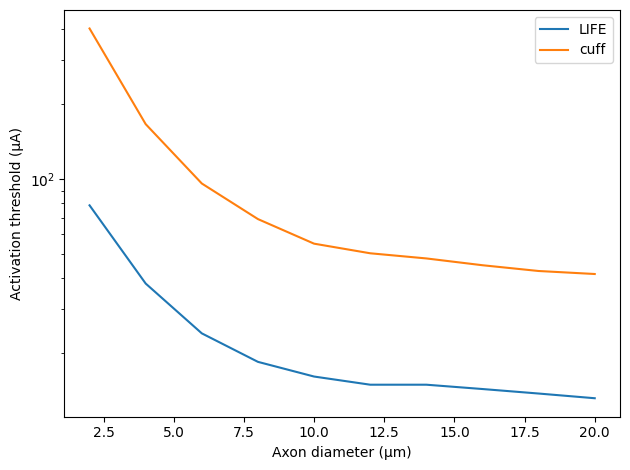

In [15]:
fig,ax = plt.subplots(1)
ax.semilogy(diam_list,thr_LIFE,label ='LIFE')
ax.semilogy(diam_list,thr_cuff,label ='cuff')
ax.legend()
ax.set_xlabel("Axon diameter (µm)")
ax.set_ylabel("Activation threshold (µA)")
fig.tight_layout()
#plt.show()